# Imports

In [1]:
import urllib.request, json
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import math
import datetime
import pickle
import math
import collections
from tqdm import tqdm
import time

# Queries

## Get the sites

### Get a list of allUK sites

Download information about all sites in the UK.

In [38]:
url_text = "https://webtris.highwaysengland.co.uk/api/v1/sites"
with urllib.request.urlopen(url_text) as url:
    data = json.loads(url.read().decode())
    
sites = data['sites']
sites[0]

{'Id': '1',
 'Name': 'MIDAS site at M4/2295A2 priority 1 on link 105009001; GPS Ref: 502816;178156; Westbound',
 'Description': 'M4/2295A2',
 'Longitude': -0.520379557723297,
 'Latitude': 51.4930115367112,
 'Status': 'Inactive'}

### Filter onto Areas

Next we are going to filter onto our train and test areas via coordinates.

The train area is Birmingham and the test area is Cambridge.

In [37]:
def get_quality_area(sites,
                     max_lat,
                     max_long,
                     min_lat,
                     min_long,
                     start_date='01062021',
                     end_date = '15062022',
                     quality_threshold = 40):
    
    # Convert sites query into df and filter onto our area
    sites_df = pd.DataFrame(data = sites)
    area_sites_df = sites_df.loc[(min_long < sites_df.Longitude) & (sites_df.Longitude < max_long)
                                & (min_lat < sites_df.Latitude) & (sites_df.Latitude < max_lat)]
    area_sites_df = area_sites_df.reset_index(drop=True)
    area_ids = list(area_sites_df.Id)
    
    # Next filter onto sites with good quality data:
    quality_responces = []
    for site_id in tqdm(area_ids):
        url_text = f"https://webtris.highwaysengland.co.uk/api/v1/quality/overall?sites={site_id}&start_date={start_date}&end_date={end_date}"
        with urllib.request.urlopen(url_text) as url:
            responce = json.loads(url.read().decode())
        quality_responces.append(responce)
        
    # We only want sites with quality greater than threshold
    good_quality_ids = []
    for responce in quality_responces:
        if responce['data_quality'] >= quality_threshold:
            good_quality_ids.append(responce['sites'])

    quality_area_sites_df = area_sites_df.loc[area_sites_df.Id.isin(good_quality_ids)]
    quality_area_sites_df = quality_area_sites_df.reset_index(drop=True)
    
    return quality_area_sites_df

In [44]:
# Specify dates
start_date='01062021'
end_date = '15062022'
# Specify the train area we are looking at
max_lat = 52.50
max_long = -1.67
min_lat = 52.42
min_long = -1.75
birmingham_sites_df = get_quality_area(sites,
                     max_lat,
                     max_long,
                     min_lat,
                     min_long,
                     start_date,
                     end_date)
# Specify dates
start_date='19042019'
end_date = '19042019'
# Specify the train area we are looking at
max_lat = 53.51
max_long = -2.32
min_lat = 53.45 
min_long = -2.39
manc_sites_df = get_quality_area(sites,
                     max_lat,
                     max_long,
                     min_lat,
                     min_long,
                     start_date,
                     end_date)
# Specify dates
# ddmmyy
start_date='02112021'
end_date = '02112021'
# Specify the train area we are looking at
max_lat = 52.25
max_long = 0.11
min_lat = 52.19
min_long = 0.02
# Get the quality reports
cam_sites_df = get_quality_area(sites,
                     max_lat,
                     max_long,
                     min_lat,
                     min_long,
                     start_date,
                     end_date)
# Specify dates
# ddmmyy
start_date='08032022'
end_date = '08032022'
# Specify the train area we are looking at
max_lat = 51.43
max_long = -0.45
min_lat = 51.38
min_long = -0.57
quality_threshold = 40
# Get the quality reports
thorpe_sites_df = get_quality_area(sites,
                     max_lat,
                     max_long,
                     min_lat,
                     min_long,
                     start_date,
                     end_date)
# Specify dates
# ddmmyy
start_date='08032022'
end_date = '08032022'
# Specify the train area we are looking at
max_lat = 51.71
max_long = 0.15
min_lat = 51.65
min_long = 0.09
quality_threshold = 40
# Get the quality reports
epping_sites_df = get_quality_area(sites,
                     max_lat,
                     max_long,
                     min_lat,
                     min_long,
                     start_date,
                     end_date)

# Specify dates
# ddmmyy
start_date='08082020'
end_date = '08082020'
# Specify the train area we are looking at
max_lat = 51.56
max_long = -2.52
min_lat = 51.53
min_long = -2.59
# Get the quality reports
bristol_sites_df = get_quality_area(sites,
                     max_lat,
                     max_long,
                     min_lat,
                     min_long,
                     start_date,
                     end_date)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:10<00:00, 11.78it/s]


### Export the site dataframes

In [45]:
birmingham_sites_df.to_feather('birmingham_sites_df')
manc_sites_df.to_feather('manc_sites_df')
cam_sites_df.to_feather('cam_sites_df')
thorpe_sites_df.to_feather('thorpe_sites_df')
epping_sites_df.to_feather('epping_sites_df')
bristol_sites_df.to_feather('bristol_sites_df')

### Import the site dataframes

In [2]:
birmingham_sites_df = pd.read_feather('site_df/birmingham_sites_df')
manc_sites_df = pd.read_feather('site_df/manc_sites_df')
cam_sites_df = pd.read_feather('site_df/cam_sites_df')
thorpe_sites_df = pd.read_feather('site_df/thorpe_sites_df')
epping_sites_df = pd.read_feather('site_df/epping_sites_df')
bristol_sites_df = pd.read_feather('site_df/bristol_sites_df')

### Export the sites to a GDF

In [41]:
import geopandas

def df_to_gdf(df):
    gdf = geopandas.GeoDataFrame(
        df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))
    return gdf

In [5]:
birmingham_sites_gdf = df_to_gdf(birmingham_sites_df)
manc_sites_gdf = df_to_gdf(manc_sites_df)
cam_sites_gdf = df_to_gdf(cam_sites_df)
thorpe_sites_gdf = df_to_gdf(thorpe_sites_df)
epping_sites_gdf = df_to_gdf(epping_sites_df)
bristol_sites_gdf = df_to_gdf(bristol_sites_df)

In [7]:
birmingham_sites_gdf.to_file("site_df/birmingham_sites_gdf.geojson", driver='GeoJSON')
manc_sites_gdf.to_file("site_df/manc_sites_gdf.geojson", driver='GeoJSON')
cam_sites_gdf.to_file("site_df/cam_sites_gdf.geojson", driver='GeoJSON')
thorpe_sites_gdf.to_file("site_df/thorpe_sites_gdf.geojson", driver='GeoJSON')
epping_sites_gdf.to_file("site_df/epping_sites_gdf.geojson", driver='GeoJSON')
bristol_sites_gdf.to_file("site_df/bristol_sites_gdf.geojson", driver='GeoJSON')

## Get Reports

### Download the reports

In [3]:
def daily_report_query_url(site_id, page_num, start_date = '15062021', end_date = '15062022'):
    query_url = f"https://webtris.highwaysengland.co.uk/api/v1/reports/Daily?sites={site_id}&start_date={start_date}&end_date={end_date}&page={page_num}&page_size=10000"
    return query_url


# Function gets the report for a particular site_id
def get_site_report(site_id, start_date='15062021', end_date='15062022'):
    # Download page 1
    report_url = daily_report_query_url(site_id, 1, start_date, end_date)
    with urllib.request.urlopen(report_url) as url:
        report_page = json.loads(url.read().decode())
        
    # Work out how many pages are required    
    header = report_page['Header']
    rows = report_page['Rows']
    row_count = header['row_count']
    total_pages = math.ceil(row_count / 10000)
    # Make a dataframe of the rows so dar
    report_df = pd.DataFrame(data = rows)
    
    for i in range(2, total_pages+1):
        # Get page i of the report
        report_url = daily_report_query_url(site_id, i, start_date, end_date)
        with urllib.request.urlopen(report_url) as url:
            report_page = json.loads(url.read().decode())
        
        rows = report_page['Rows']
        current_page_df = pd.DataFrame(data = rows)
        report_df = pd.concat([report_df, current_page_df], ignore_index=True)

    return report_df, header

# Function takes a dataframe of site_df and gets the reports
def get_reports_from_sites_df(sites_df, start_date, end_date):
    # Get the reports on the site
    train_reports =  collections.defaultdict(str)
    # Go through all the site ids and get reports
    for site_id in tqdm(sites_df.Id):
        report, header = get_site_report(site_id, start_date, end_date)
        report['site_id'] = site_id
        train_reports[site_id] = report
        
    # Combine reports into one df
    report_df = pd.concat(list(train_reports.values()), ignore_index=True)
    return report_df

In [ ]:
# Take the start and end dates as the maximum and minima of the datas + a month
start_date='19032019'
end_date = '08042022'

birmingham_report_df = get_reports_from_sites_df(birmingham_sites_df, start_date, end_date)
birmingham_report_df.to_feather('traffic_reports/birmingham_report_df')

manc_report_df = get_reports_from_sites_df(manc_sites_df, start_date, end_date)
manc_report_df.to_feather('traffic_reports/manc_report_df')

cam_report_df = get_reports_from_sites_df(cam_sites_df, start_date, end_date)
cam_report_df.to_feather('traffic_reports/cam_report_df')

thorpe_report_df = get_reports_from_sites_df(thorpe_sites_df, start_date, end_date)
thorpe_report_df.to_feather('traffic_reports/thorpe_report_df')

epping_report_df = get_reports_from_sites_df(epping_sites_df, start_date, end_date)
epping_report_df.to_feather('traffic_reports/epping_report_df')

bristol_report_df = get_reports_from_sites_df(bristol_sites_df, start_date, end_date)
bristol_report_df.to_feather('traffic_reports/bristol_report_df')

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 32/64 [1:19:51<7:30:59, 845.61s/it]

In [5]:
# Take the start and end dates as the maximum and minima of the datas + a month
start_date='19032019'
end_date = '08042022'
bristol_report_df = get_reports_from_sites_df(bristol_sites_df, start_date, end_date)
bristol_report_df.to_feather('traffic_reports/bristol_report_df')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [25:13<00:00, 23.65s/it]


### Import reports

In [2]:
birmingham_report_df = pd.read_feather('traffic_reports/birmingham_report_df')
manc_report_df = pd.read_feather('traffic_reports/manc_report_df')
cam_report_df = pd.read_feather('traffic_reports/cam_report_df')
thorpe_report_df = pd.read_feather('traffic_reports/thorpe_report_df')
epping_report_df = pd.read_feather('traffic_reports/epping_report_df')
bristol_report_df = pd.read_feather('traffic_reports/bristol_report_df')

## Data Cleaning

### Reformat col names

In [3]:
clean_col_names = [
    'site_name',
    'report_date',
    'time_period_ending',
    'time_interval',
    '0-520cm',
    '521-660cm',
    '661-1160cm',
    '1160+cm',
    '0-10mph',
    '11-15mph',
    '16-20mph',
    '21-25mph',
    '26-30mph',
    '31-35mph',
    '36-40mph',
    '41-45mph',
    '46-50mph',
    '51-55mph',
    '56-60mph',
    '61-70mph',
    '71-80mph',
    '80+mph',
    'avg_mph',
    'total_volume',
    'site_id'
]

In [4]:
birmingham_report_df.columns = clean_col_names
manc_report_df.columns = clean_col_names
cam_report_df.columns = clean_col_names
thorpe_report_df.columns = clean_col_names
epping_report_df.columns = clean_col_names
bristol_report_df.columns = clean_col_names

In [5]:
clean_cols = [
     'site_name',
     'site_id',
     'report_date',
     'time_period_ending',
     'time_interval',
     '0-520cm',
     '521-660cm',
     '661-1160cm',
     '1160+cm',
     'avg_mph',
     'total_volume']

In [6]:
clean_birmingham_report_df = birmingham_report_df[clean_cols]
clean_manc_report_df = manc_report_df[clean_cols]
clean_cam_report_df = cam_report_df[clean_cols]
clean_thorpe_report_df = thorpe_report_df[clean_cols]
clean_epping_report_df = epping_report_df[clean_cols]
clean_bristol_report_df = bristol_report_df[clean_cols]

In [7]:
# Specify which cols are to be converted to numerical data
interger_cols = [
     '0-520cm',
     '521-660cm',
     '661-1160cm',
     '1160+cm',
     'total_volume']

### Remove empty cols and convert to interger

In [8]:
def remove_rows(df):
    df = df.loc[df['total_volume'] != '']
    df.loc[:,interger_cols] = df[interger_cols].astype('int32')
    return df

clean_birmingham_report_df = remove_rows(clean_birmingham_report_df)
clean_manc_report_df = remove_rows(clean_manc_report_df)
clean_cam_report_df = remove_rows(clean_cam_report_df)
clean_thorpe_report_df = remove_rows(clean_thorpe_report_df)
clean_epping_report_df = remove_rows(clean_epping_report_df)
clean_bristol_report_df = remove_rows(clean_bristol_report_df)

/tmp/ipykernel_943722/23444757.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,interger_cols] = df[interger_cols].astype('int32')
/tmp/ipykernel_943722/23444757.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,interger_cols] = df[interger_cols].astype('int32')
/tmp/ipykernel_943722/23444757.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,interger_cols] = df[interger_cols].astype('int32')
/tmp/ipyke

### Add timestamp and Export

In [9]:
def get_timestamp(row):
    year, month,day = row['report_date'].split('T')[0].split('-')
    hour, minute, second = row['time_period_ending'].split(':')
    return datetime.datetime(int(year),int(month),int(day), int(hour), int(minute))

def add_time_data(clean_report):
    clean_report.loc[:,'timestamp'] = clean_report.apply(get_timestamp,axis=1)
    clean_report.loc[:,'hour'] = clean_report.timestamp.dt.hour.astype(str)
    clean_report.loc[:,'DOW'] =  clean_report.timestamp.dt.day_of_week.astype(str)
    clean_report.loc[:,'month'] = clean_report.timestamp.dt.month.astype(str)
    return clean_report

# clean_test_report_df = add_time_data(clean_test_report_df)
# clean_train_report_df = add_time_data(clean_train_report_df)

In [10]:
clean_birmingham_report_df = add_time_data(clean_birmingham_report_df)
clean_birmingham_report_df.reset_index(drop=True).to_feather('traffic_reports/clean/clean_birmingham_report_df')

In [11]:
clean_manc_report_df = add_time_data(clean_manc_report_df)
clean_manc_report_df.reset_index(drop=True).to_feather('traffic_reports/clean/clean_manc_report_df')

In [12]:
clean_cam_report_df = add_time_data(clean_cam_report_df)
clean_cam_report_df.reset_index(drop=True).to_feather('traffic_reports/clean/clean_cam_report_df')

In [13]:
clean_thorpe_report_df = add_time_data(clean_thorpe_report_df)
clean_thorpe_report_df.reset_index(drop=True).to_feather('traffic_reports/clean/clean_thorpe_report_df')

In [14]:
clean_epping_report_df = add_time_data(clean_epping_report_df)
clean_epping_report_df.reset_index(drop=True).to_feather('traffic_reports/clean/clean_epping_report_df')

In [15]:
clean_bristol_report_df = add_time_data(clean_bristol_report_df)
clean_bristol_report_df.reset_index(drop=True).to_feather('traffic_reports/clean/clean_bristol_report_df')

In [16]:
clean_bristol_report_df

,site_name,site_id,report_date,time_period_ending,time_interval,0-520cm,521-660cm,661-1160cm,1160+cm,avg_mph,total_volume,timestamp,hour,DOW,month
233,M4/3869B,90,2019-03-21T00:00:00,10:29:00,41,300,75,15,60,57,450,2019-03-21 10:29:00,10,3,3
234,M4/3869B,90,2019-03-21T00:00:00,10:44:00,42,235,28,20,47,58,330,2019-03-21 10:44:00,10,3,3
235,M4/3869B,90,2019-03-21T00:00:00,10:59:00,43,262,27,33,40,61,362,2019-03-21 10:59:00,10,3,3
236,M4/3869B,90,2019-03-21T00:00:00,11:14:00,44,252,40,28,44,64,364,2019-03-21 11:14:00,11,3,3
237,M4/3869B,90,2019-03-21T00:00:00,11:29:00,45,232,23,33,37,63,325,2019-03-21 11:29:00,11,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6844251,5275/1,7486,2022-04-08T00:00:00,22:59:00,91,125,3,3,16,56,147,2022-04-08 22:59:00,22,4,4
6844252,5275/1,7486,2022-04-08T00:00:00,23:14:00,92,113,6,3,8,57,130,2022-04-08 23:14:00,23,4,4
6844253,5275/1,7486,2022-04-08T00:00:00,23:29:00,93,97,1,5,10,55,113,2022-04-08 23:29:00,23,4,4
6844254,5275/1,7486,2022-04-08T00:00:00,23:44:00,94,84,3,4,9,55,100,2022-04-08 23:44:00,23,4,4


### Import clean reports

In [3]:
clean_birmingham_report_df = pd.read_feather('traffic_reports/clean/clean_birmingham_report_df')
clean_manc_report_df = pd.read_feather('traffic_reports/clean/clean_manc_report_df')
clean_cam_report_df = pd.read_feather('traffic_reports/clean/clean_cam_report_df')
clean_thorpe_report_df = pd.read_feather('traffic_reports/clean/clean_thorpe_report_df')
clean_epping_report_df = pd.read_feather('traffic_reports/clean/clean_epping_report_df')
clean_bristol_report_df = pd.read_feather('traffic_reports/clean/clean_bristol_report_df')

In [7]:
clean_birmingham_report_df['location'] = 'birmingham'
clean_manc_report_df['location'] = 'manchester'
clean_cam_report_df['location'] = 'cambridge'
clean_thorpe_report_df['location'] = 'thorpe'
clean_epping_report_df['location'] = 'epping'
clean_bristol_report_df['location'] = 'bristol'

### Export as one full report

In [10]:
full_clean_report = pd.concat([clean_birmingham_report_df, clean_manc_report_df, clean_cam_report_df, clean_thorpe_report_df, clean_epping_report_df, clean_bristol_report_df], ignore_index=True)

In [12]:
full_clean_report.to_feather('traffic_reports/clean/full_clean_report')

### Import Full report

In [2]:
full_clean_report = pd.read_feather('traffic_reports/clean/full_clean_report')

In [3]:
full_clean_report

,site_name,site_id,report_date,time_period_ending,time_interval,0-520cm,521-660cm,661-1160cm,1160+cm,avg_mph,total_volume,timestamp,hour,DOW,month,location
0,M42/6482L,175,2019-03-19T00:00:00,00:14:00,0,19,4,8,18,62,49,2019-03-19 00:14:00,0,1,3,birmingham
1,M42/6482L,175,2019-03-19T00:00:00,00:29:00,1,7,4,8,17,57,36,2019-03-19 00:29:00,0,1,3,birmingham
2,M42/6482L,175,2019-03-19T00:00:00,00:44:00,2,13,3,5,8,61,29,2019-03-19 00:44:00,0,1,3,birmingham
3,M42/6482L,175,2019-03-19T00:00:00,00:59:00,3,17,2,4,20,59,43,2019-03-19 00:59:00,0,1,3,birmingham
4,M42/6482L,175,2019-03-19T00:00:00,01:14:00,4,15,6,12,16,61,49,2019-03-19 01:14:00,1,1,3,birmingham
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24202226,5275/1,7486,2022-04-08T00:00:00,22:59:00,91,125,3,3,16,56,147,2022-04-08 22:59:00,22,4,4,bristol
24202227,5275/1,7486,2022-04-08T00:00:00,23:14:00,92,113,6,3,8,57,130,2022-04-08 23:14:00,23,4,4,bristol
24202228,5275/1,7486,2022-04-08T00:00:00,23:29:00,93,97,1,5,10,55,113,2022-04-08 23:29:00,23,4,4,bristol
24202229,5275/1,7486,2022-04-08T00:00:00,23:44:00,94,84,3,4,9,55,100,2022-04-08 23:44:00,23,4,4,bristol


In [12]:
full_clean_report.timestamp.dt.day.unique()

array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [19]:
full_clean_report[(full_clean_report.timestamp.dt.year == 2022) & 
                  (full_clean_report.timestamp.dt.month == 3) & 
                  (full_clean_report.timestamp.dt.day == 8) &
                  (full_clean_report.site_id == '3798')]

,site_name,site_id,report_date,time_period_ending,time_interval,0-520cm,521-660cm,661-1160cm,1160+cm,avg_mph,total_volume,timestamp,hour,DOW,month,location
16931269,M11/6237A,3798,2022-03-08T00:00:00,00:14:00,0,48,1,0,4,67,53,2022-03-08 00:14:00,0,1,3,epping
16931270,M11/6237A,3798,2022-03-08T00:00:00,00:29:00,1,51,1,5,1,66,58,2022-03-08 00:29:00,0,1,3,epping
16931271,M11/6237A,3798,2022-03-08T00:00:00,00:44:00,2,30,1,3,1,70,35,2022-03-08 00:44:00,0,1,3,epping
16931272,M11/6237A,3798,2022-03-08T00:00:00,00:59:00,3,24,0,2,3,67,29,2022-03-08 00:59:00,0,1,3,epping
16931273,M11/6237A,3798,2022-03-08T00:00:00,01:14:00,4,19,0,0,6,64,25,2022-03-08 01:14:00,1,1,3,epping
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16931360,M11/6237A,3798,2022-03-08T00:00:00,22:59:00,91,102,0,3,5,69,110,2022-03-08 22:59:00,22,1,3,epping
16931361,M11/6237A,3798,2022-03-08T00:00:00,23:14:00,92,63,2,2,3,67,70,2022-03-08 23:14:00,23,1,3,epping
16931362,M11/6237A,3798,2022-03-08T00:00:00,23:29:00,93,20,0,0,0,69,20,2022-03-08 23:29:00,23,1,3,epping
16931363,M11/6237A,3798,2022-03-08T00:00:00,23:44:00,94,1,0,0,0,61,1,2022-03-08 23:44:00,23,1,3,epping


### Some exploratory plots of each regional dataset

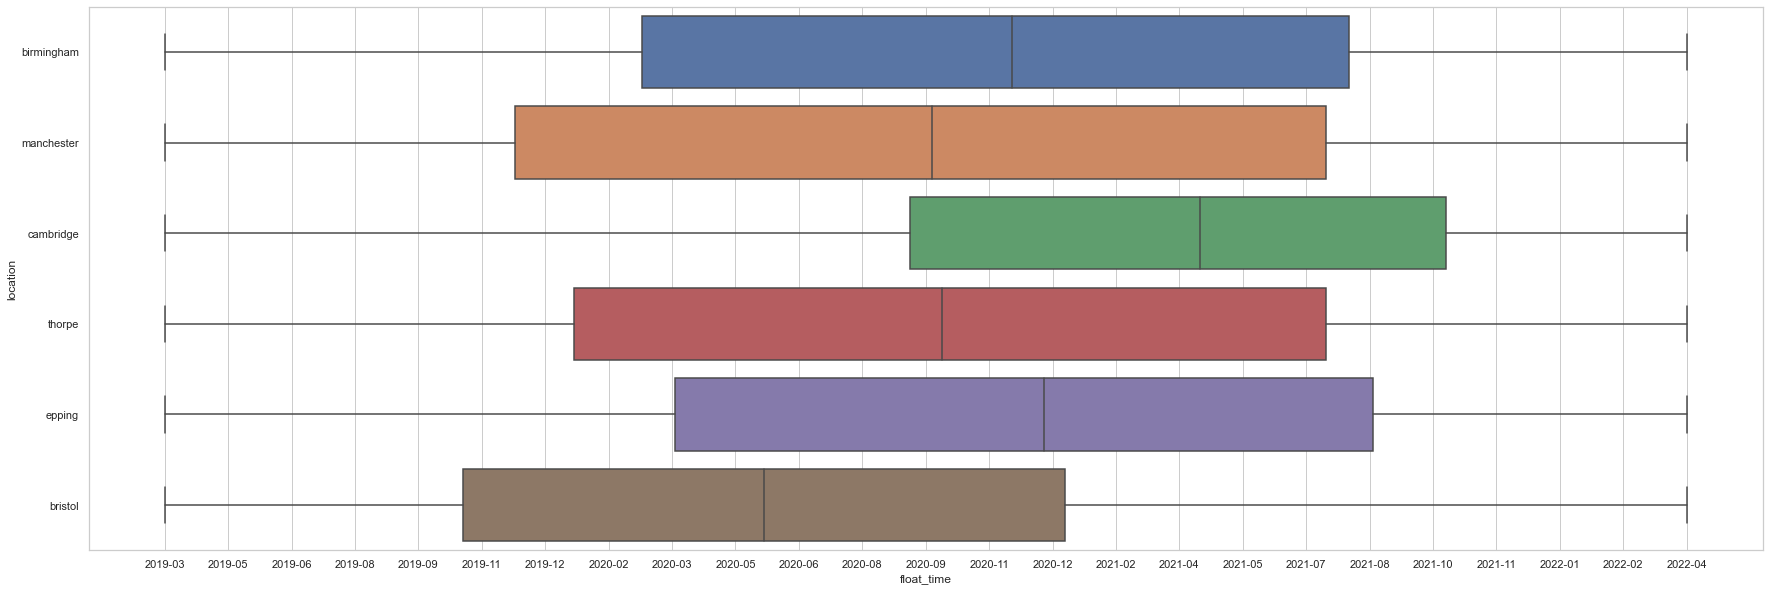

In [6]:
import seaborn as sns
# import matplotlib.ticker as ticker
import numpy as np

full_clean_report['float_time'] = full_clean_report.timestamp.astype(int)/1E9

@plt.FuncFormatter
def convert_to_date_string(x,pos):
    return time.strftime('%Y-%m',time.localtime(x))

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(30,10))
sns.boxplot(data = full_clean_report, x = 'float_time', y="location")
ax.xaxis.set_major_formatter(convert_to_date_string)
ax.xaxis.set_ticks(np.linspace(full_clean_report.float_time.min(), full_clean_report.float_time.max() , 25))
plt.show()

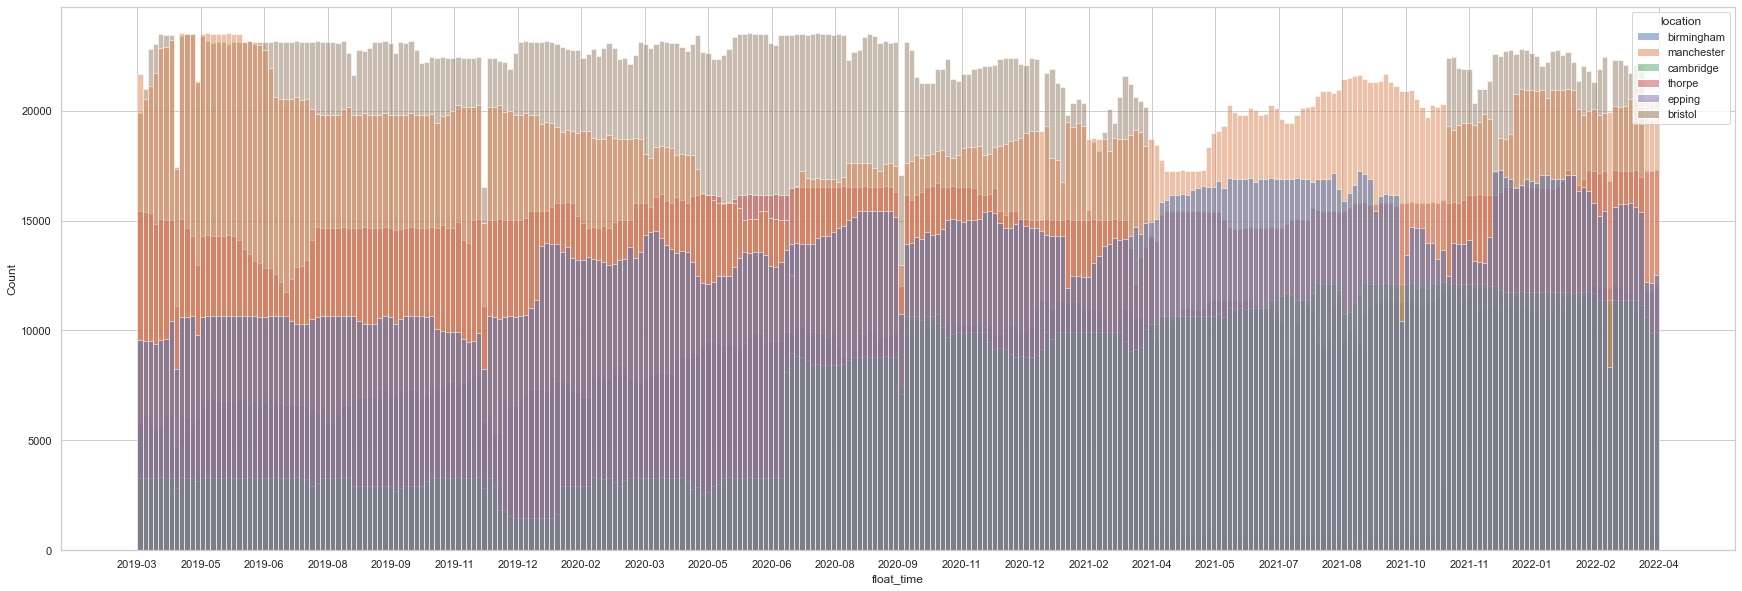

In [7]:
fig, ax = plt.subplots(figsize=(30,10))
ax = sns.histplot(data=full_clean_report, x = 'float_time', hue="location")
ax.xaxis.set_major_formatter(convert_to_date_string)
ax.xaxis.set_ticks(np.linspace(full_clean_report.float_time.min(), full_clean_report.float_time.max() , 25))
plt.show()

### Normalise Counts for each site ID

In [8]:
def normalise(clean_report):
    for name in interger_cols:
        new_name = f"{name}_normalised"
        mean = clean_report.groupby('site_id')[name].transform("mean")
        clean_report.loc[:, new_name] = clean_report[name] / mean
    return clean_report


# Specify which cols are to be converted to numerical data
interger_cols = [
     '0-520cm',
     '521-660cm',
     '661-1160cm',
     '1160+cm',
     'total_volume']

full_clean_report = normalise(full_clean_report)

### New Check Plots

<AxesSubplot:xlabel='timestamp', ylabel='total_volume_normalised'>

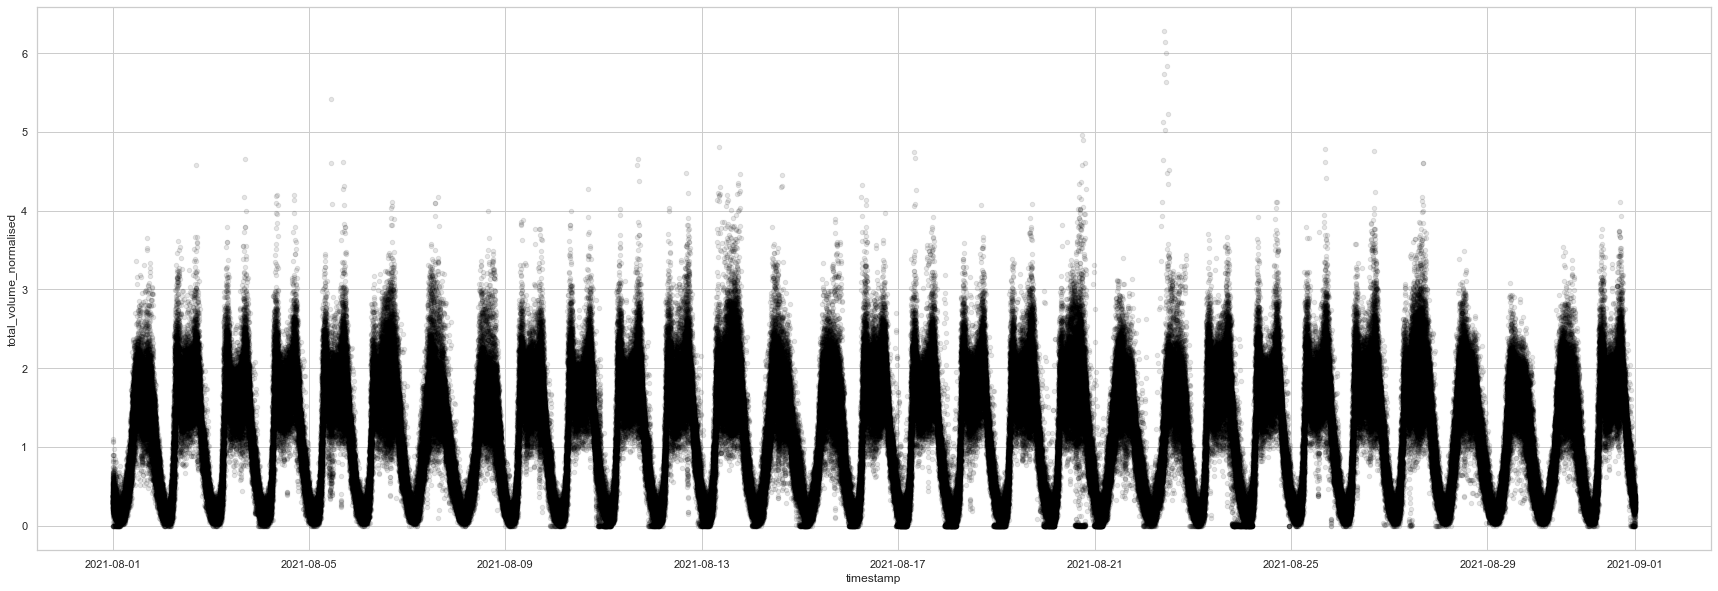

In [9]:
full_clean_report = full_clean_report.loc[full_clean_report['timestamp'].dt.to_period('M')  == '2021-08']
full_clean_report.plot('timestamp','total_volume_normalised', figsize = (30,10), kind = 'scatter', alpha=0.1, c='black')

### Plot to check all is well

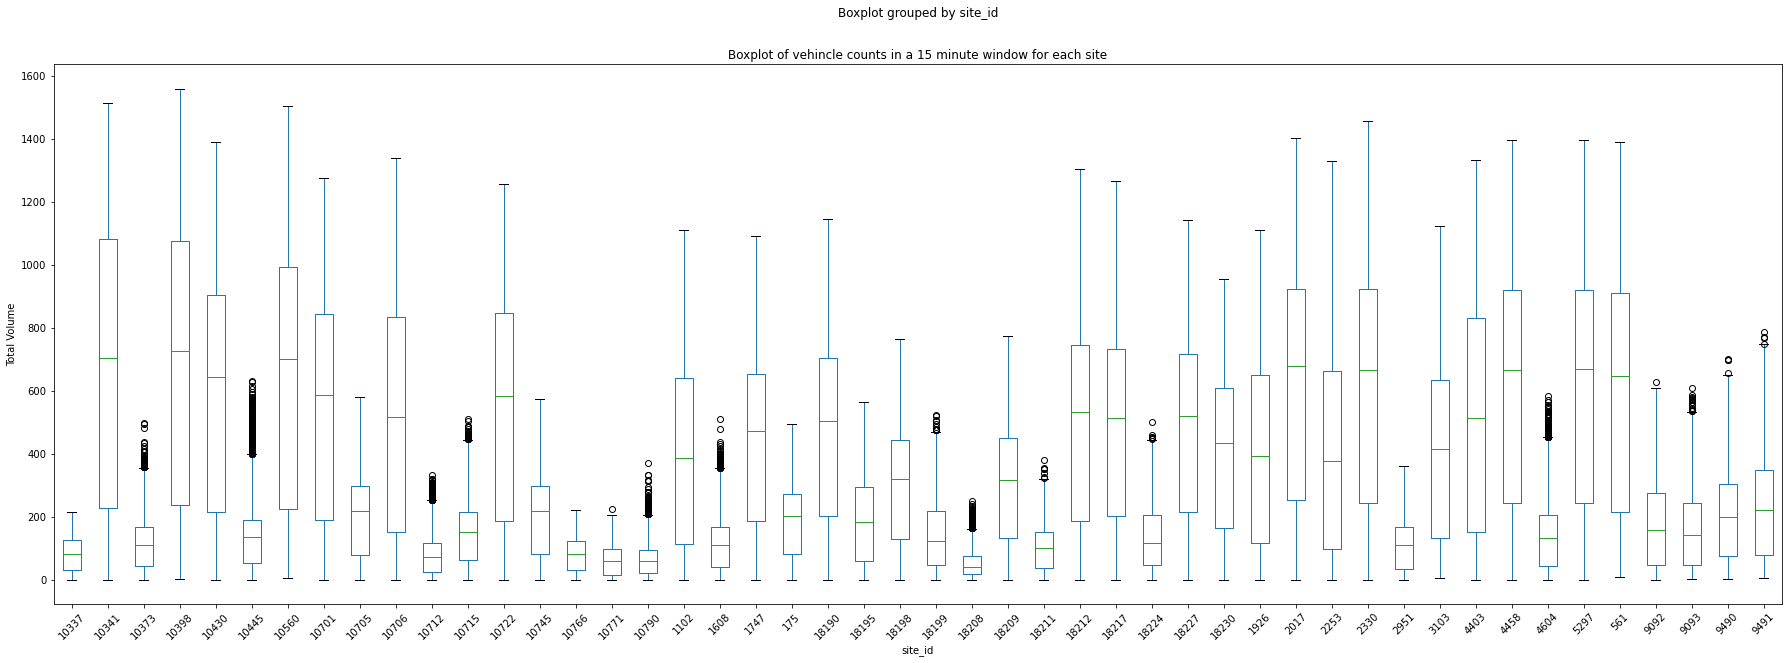

In [12]:
fig, ax = plt.subplots(figsize=(30,10))
clean_train_report_df.boxplot(column='total_volume', by = 'site_id', ax=ax, grid=False, rot=45)
ax.set_title('Boxplot of vehincle counts in a 15 minute window for each site')
ax.set_ylabel('Total Volume')
plt.show()

<AxesSubplot:xlabel='timestamp', ylabel='total_volume_normalised'>

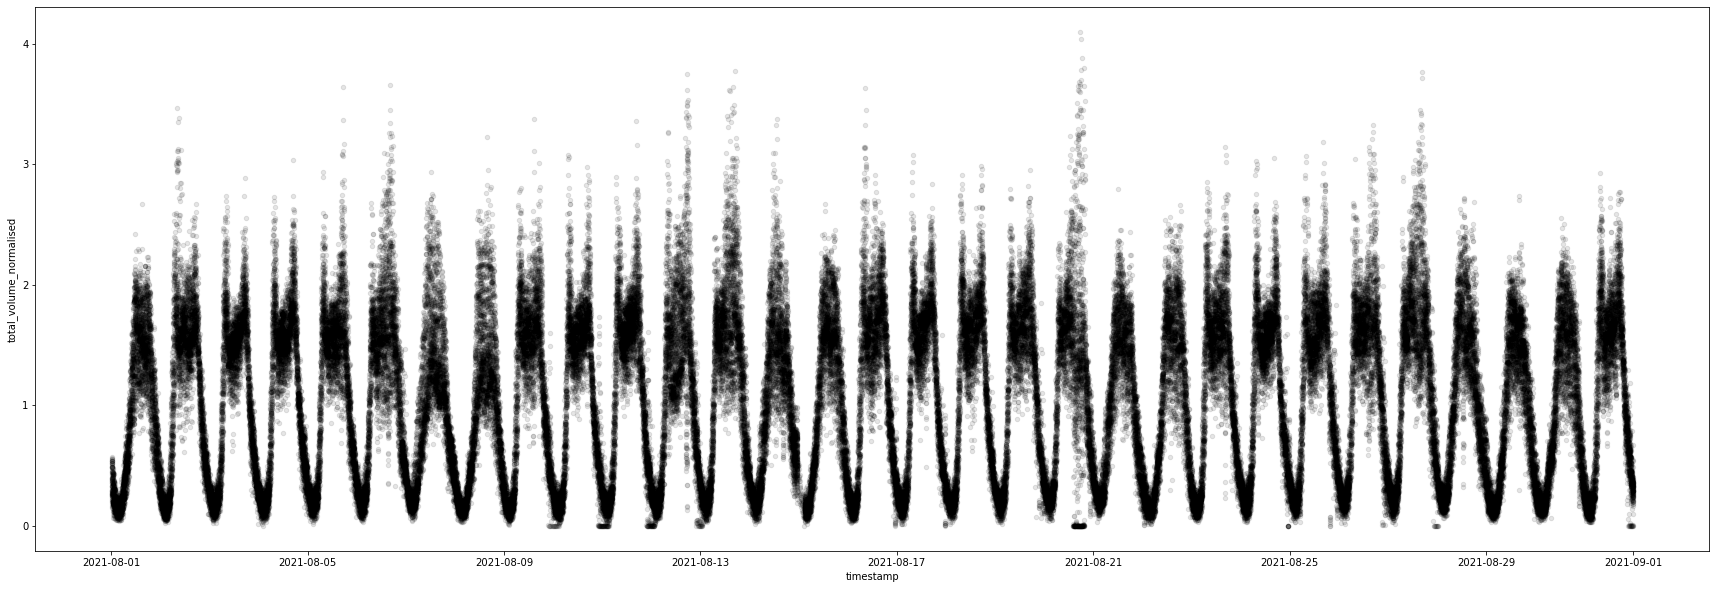

In [13]:
filterd_report = clean_train_report_df.loc[clean_train_report_df['timestamp'].dt.to_period('M')  == '2021-08']
filterd_report.plot('timestamp','total_volume_normalised', figsize = (30,10), kind = 'scatter', alpha=0.1, c='black')

<AxesSubplot:xlabel='timestamp', ylabel='total_volume_normalised'>

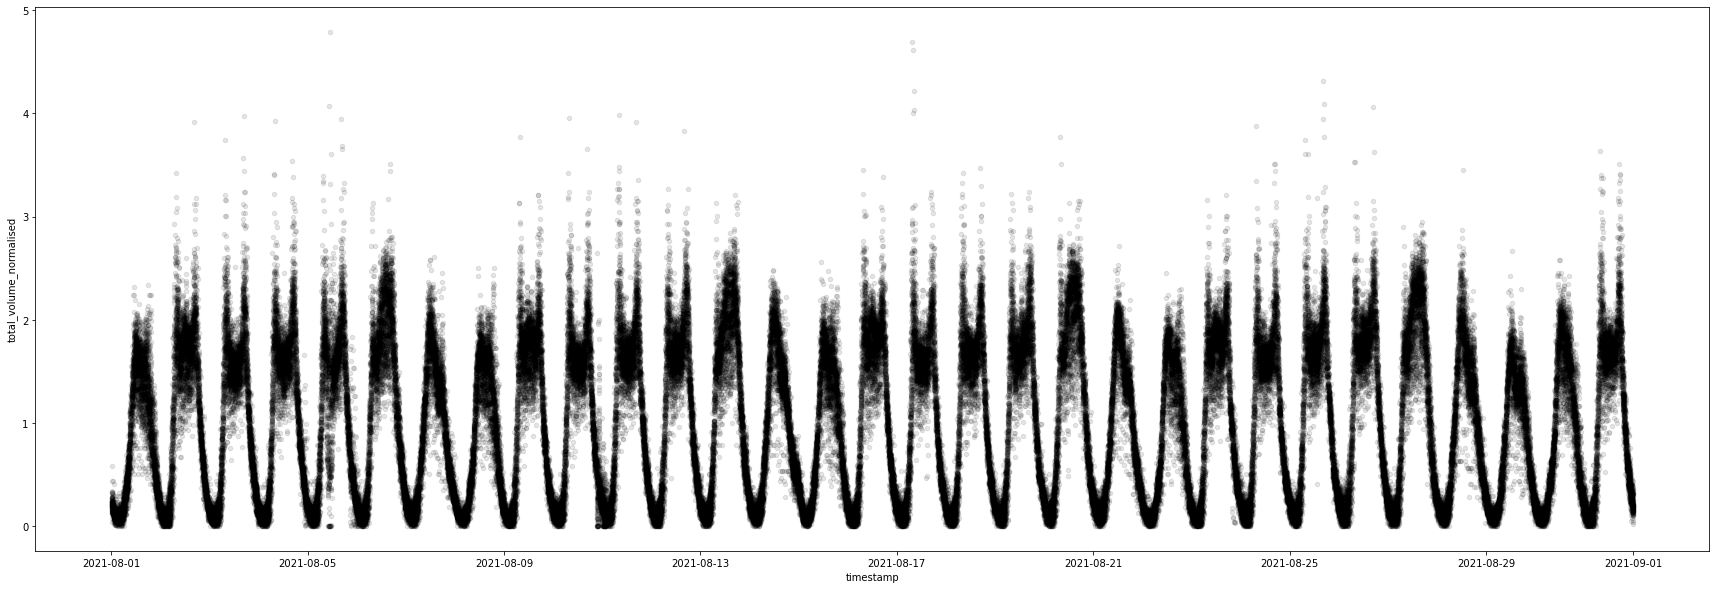

In [14]:
filterd_report = clean_test_report_df.loc[clean_test_report_df['timestamp'].dt.to_period('M')  == '2021-08']
filterd_report.plot('timestamp','total_volume_normalised', figsize = (30,10), kind = 'scatter', alpha=0.1, c='black')

In [15]:
clean_test_report_df

,site_name,site_id,report_date,time_period_ending,time_interval,0-520cm,521-660cm,661-1160cm,1160+cm,avg_mph,total_volume,timestamp,hour,DOW,month,0-520cm_normalised,521-660cm_normalised,661-1160cm_normalised,1160+cm_normalised,total_volume_normalised
3336,M11/6904A,65,2021-07-05T00:00:00,18:14:00,72,386,39,17,84,61,525,2021-07-05 18:14:00,18,0,7,2.098724,3.058174,1.863647,2.508286,2.194041
3337,M11/6904A,65,2021-07-05T00:00:00,18:29:00,73,338,27,12,69,62,446,2021-07-05 18:29:00,18,0,7,1.837743,2.117198,1.315515,2.060378,1.86389
3338,M11/6904A,65,2021-07-05T00:00:00,18:44:00,74,271,16,8,64,63,359,2021-07-05 18:44:00,18,0,7,1.473457,1.254636,0.87701,1.911075,1.500306
3339,M11/6904A,65,2021-07-05T00:00:00,18:59:00,75,236,19,11,46,64,312,2021-07-05 18:59:00,18,0,7,1.283158,1.48988,1.205889,1.373585,1.303888
3340,M11/6904A,65,2021-07-05T00:00:00,19:14:00,76,185,9,8,52,62,254,2021-07-05 19:14:00,19,0,7,1.005865,0.705733,0.87701,1.552749,1.061498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819579,M11/6914L,18858,2022-06-15T00:00:00,22:59:00,91,6,1,0,1,60,8,2022-06-15 22:59:00,22,2,6,0.188962,0.237194,0.0,1.614685,0.210895
1819580,M11/6914L,18858,2022-06-15T00:00:00,23:14:00,92,2,0,0,0,56,2,2022-06-15 23:14:00,23,2,6,0.062987,0.0,0.0,0.0,0.052724
1819581,M11/6914L,18858,2022-06-15T00:00:00,23:29:00,93,3,0,0,0,58,3,2022-06-15 23:29:00,23,2,6,0.094481,0.0,0.0,0.0,0.079086
1819582,M11/6914L,18858,2022-06-15T00:00:00,23:44:00,94,7,2,0,0,58,9,2022-06-15 23:44:00,23,2,6,0.220456,0.474389,0.0,0.0,0.237257


### Export the cleaned reports

In [98]:
clean_train_report_df.reset_index(drop=True).to_feather('clean_train_report_df.feather')
clean_test_report_df.reset_index(drop=True).to_feather('clean_test_report_df.feather')

# Normalised Flow Model

In [34]:
clean_test_report_df = pd.read_feather('clean_train_report_df.feather')
clean_train_report_df = pd.read_feather('clean_test_report_df.feather')

In [10]:
import numpy as np
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [22]:
clean_train_report_df = full_clean_report[full_clean_report.location != 'epping']
clean_test_report_df  = full_clean_report[full_clean_report.location == 'epping']

In [23]:
# Pick cols for model
cols = ['total_volume_normalised', 'hour', 'DOW', 'month']
# Train and test data are made from these
data_train = clean_train_report_df[cols]
data_test = clean_test_report_df[cols]
data_train

,total_volume_normalised,hour,DOW,month
82795,0.443918,0,6,8
82796,0.326253,0,6,8
82797,0.304860,0,6,8
82798,0.310208,0,6,8
82799,0.278118,1,6,8
...,...,...,...,...
24181180,2.050802,11,1,8
24181181,2.104302,12,1,8
24181182,1.813028,14,1,8
24181183,1.667392,14,1,8


In [24]:
data_train.DOW.unique()

array(['6', '0', '1', '2', '3', '4', '5'], dtype=object)

In [25]:
data_train.hour.unique()

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'],
      dtype=object)

In [26]:
data_test

,total_volume_normalised,hour,DOW,month
16323465,1.409841,17,0,8
16323466,1.629150,17,0,8
16323467,1.712696,17,0,8
16323468,1.660480,17,0,8
16323469,1.827572,16,2,8
...,...,...,...,...
18958147,0.481115,22,1,8
18958148,0.292162,23,1,8
18958149,0.312804,23,1,8
18958150,0.268345,23,1,8


In [18]:
y_train, X_train = dmatrices("total_volume_normalised ~ hour*DOW", data_train)

In [27]:
# Make the model matrix and predictions
y_train, X_train = dmatrices("total_volume_normalised ~ hour*DOW", data_train)
# Create model matrix for test data
y_test, X_test = dmatrices("total_volume_normalised ~ hour*DOW", data_test)

model = LinearRegression()
model.fit(X_train,y_train)

# Make predictions on train data
predictions_train = model.predict(X_train)
# Make predictions on test data
predictions_test = model.predict(X_test)

/vol/bitbucket/jrb21/anaconda3/envs/sklearn-env/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


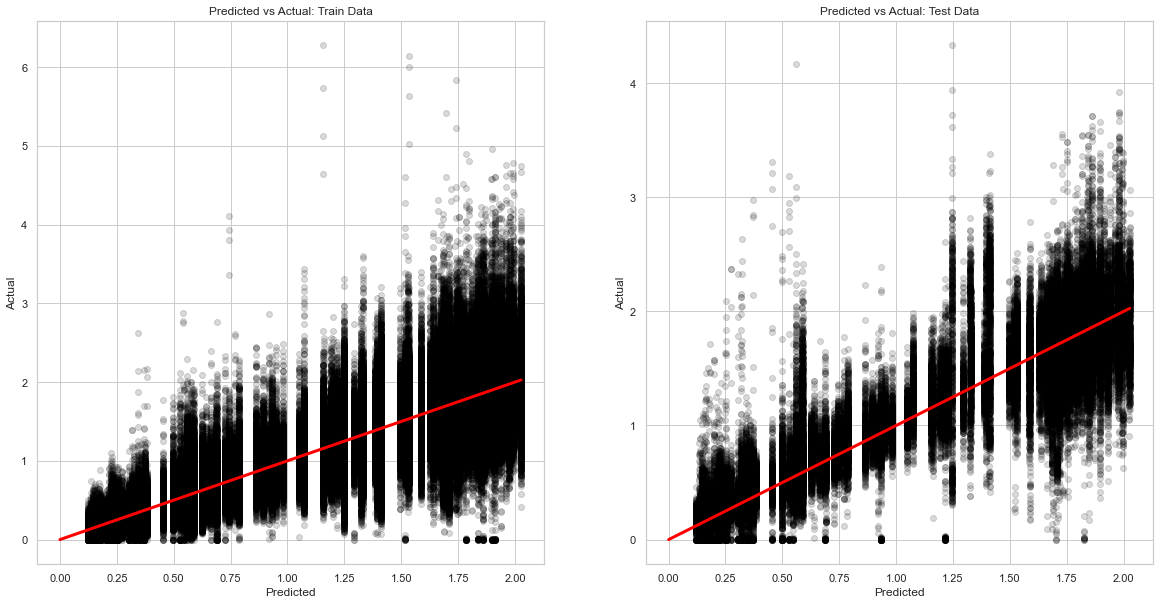

In [28]:
# Plot predictions vs actual
fig, ax = plt.subplots(1,2,figsize=(20,10))

ax[0].scatter(predictions_train, y_train,  alpha = 0.15, c='black')
xmax = max(predictions_train)
ax[0].plot([0,xmax],[0,xmax], lw=3, c='red')
ax[0].set_title('Predicted vs Actual: Train Data')
ax[0].set_ylabel('Actual')
ax[0].set_xlabel('Predicted')

ax[1].scatter(predictions_test, y_test,  alpha = 0.15, c='black')
xmax = max(predictions_test)
ax[1].plot([0,xmax],[0,xmax], lw=3, c='red')
ax[1].set_title('Predicted vs Actual: Test Data')
ax[1].set_ylabel('Actual')
ax[1].set_xlabel('Predicted')

plt.show()

In [29]:
clean_test_report_df.loc[:,'total_volume_normalised_predictions'] = predictions_test

/tmp/ipykernel_90647/2494417549.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_test_report_df.loc[:,'total_volume_normalised_predictions'] = predictions_test


In [32]:
clean_test_report_df

,site_name,site_id,report_date,time_period_ending,time_interval,0-520cm,521-660cm,661-1160cm,1160+cm,avg_mph,...,DOW,month,location,float_time,0-520cm_normalised,521-660cm_normalised,661-1160cm_normalised,1160+cm_normalised,total_volume_normalised,total_volume_normalised_predictions
16323465,M25/5614L,1548,2021-08-02T00:00:00,17:14:00,68,98,30,8,0,66,...,0,8,epping,1.627924e+09,1.569650,2.119834,0.901052,0.000000,1.409841,1.849020
16323466,M25/5614L,1548,2021-08-02T00:00:00,17:29:00,69,123,17,7,9,64,...,0,8,epping,1.627925e+09,1.970071,1.201239,0.788421,0.874551,1.629150,1.849020
16323467,M25/5614L,1548,2021-08-02T00:00:00,17:44:00,70,123,19,15,7,65,...,0,8,epping,1.627926e+09,1.970071,1.342562,1.689473,0.680207,1.712696,1.849020
16323468,M25/5614L,1548,2021-08-02T00:00:00,17:57:00,71,119,16,8,16,65,...,0,8,epping,1.627927e+09,1.906004,1.130578,0.901052,1.554758,1.660480,1.849020
16323469,M25/5614L,1548,2021-08-11T00:00:00,16:59:00,67,145,10,15,5,67,...,2,8,epping,1.628701e+09,2.322442,0.706611,1.689473,0.485862,1.827572,1.991071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18958147,M25/5580A,10564,2021-08-31T00:00:00,22:59:00,91,181,57,17,48,53,...,1,8,epping,1.630451e+09,0.513267,0.537618,0.269573,0.444202,0.481115,0.527648
18958148,M25/5580A,10564,2021-08-31T00:00:00,23:14:00,92,122,33,5,24,53,...,1,8,epping,1.630452e+09,0.345959,0.311253,0.079286,0.222101,0.292162,0.324081
18958149,M25/5580A,10564,2021-08-31T00:00:00,23:29:00,93,126,27,11,33,64,...,1,8,epping,1.630453e+09,0.357302,0.254661,0.174430,0.305389,0.312804,0.324081
18958150,M25/5580A,10564,2021-08-31T00:00:00,23:44:00,94,105,24,12,28,63,...,1,8,epping,1.630453e+09,0.297752,0.226366,0.190287,0.259118,0.268345,0.324081


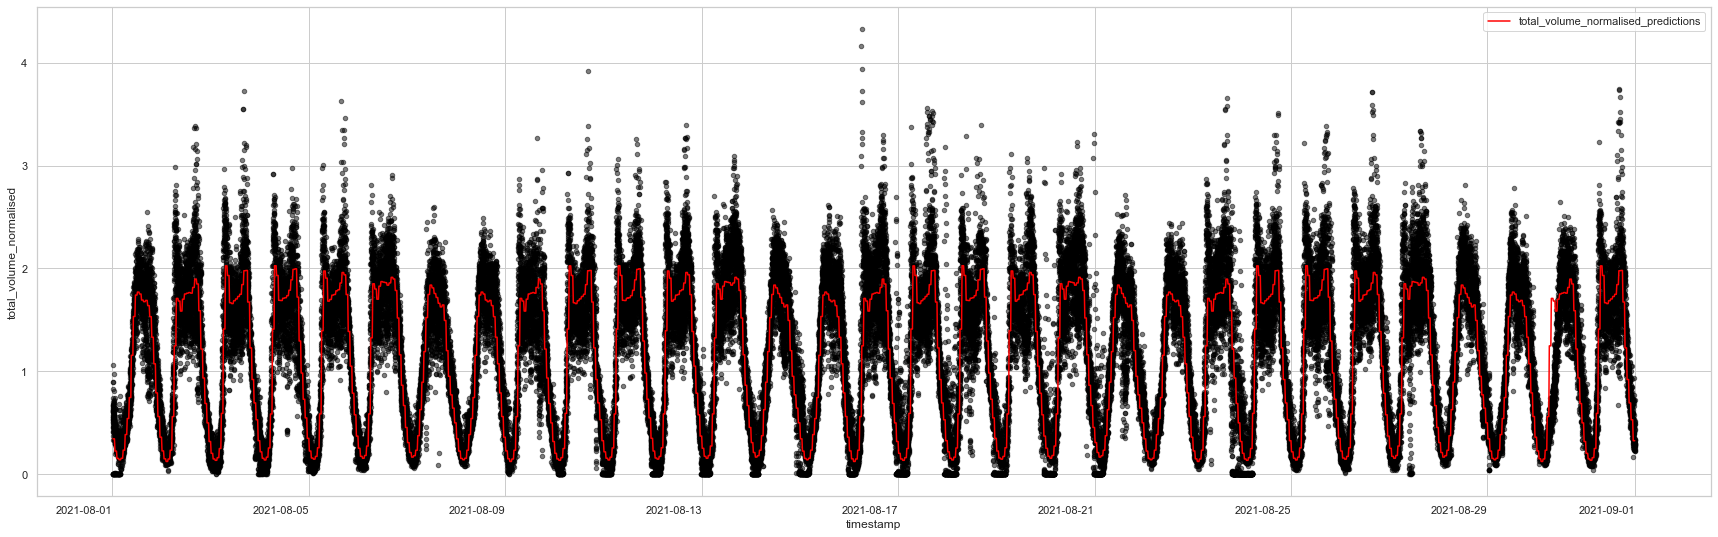

In [33]:
# Focus on particular month so we can actually see the data
filterd_report = clean_test_report_df.loc[clean_test_report_df['timestamp'].dt.to_period('M')  == '2021-08']

fig, ax = plt.subplots(figsize=(20,5))
filterd_report.plot('timestamp','total_volume_normalised_predictions', figsize = (30,10), c='red', kind='line', ax=ax)
filterd_report.plot('timestamp','total_volume_normalised', figsize = (30,10), c='black', kind='scatter', alpha=0.5, ax=ax)
plt.show()

<AxesSubplot:xlabel='timestamp'>

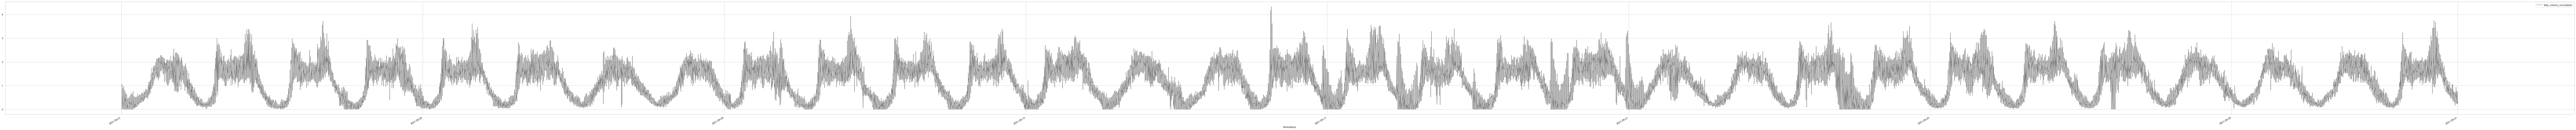

In [34]:
clean_test_report_df.plot('timestamp','total_volume_normalised', figsize = (200,10), c='black', kind='line', alpha=0.5)

In [35]:
def test_report(y_true, y_pred):
    print(f"MSE: {mean_squared_error(y_true, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred)}")
    print(f"R^2: {r2_score(y_true, y_pred)}")
test_report(y_test,predictions_test)

MSE: 0.1000071501388039
MAE: 0.22018519847582374
R^2: 0.8051307293431721
